## Topic Modeling By Threshold

Lines of code: ~ 520

Motivation: This notebook applies LDA to generate topics with the threshold dataset to understand broader themes around climate change discourse on Reddit.

By Shwetha Srinivasan

### Importing relevant libraries

In [ ]:
!pip install pyLDAvis


In [ ]:
import warnings

# Ignore the DeprecationWarning related to should_run_async
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords

import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
import regex as re

import pyLDAvis.gensim

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import spacy


In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
!python -m spacy download en_core_web_md

### Reading in Threshold Data

In [15]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
path_gdrive = '/content/drive/Shareddrives/adv-ml-project/Data'
df_comments = pd.read_csv(path_gdrive + '/' + 'by_threshold/comments_filtered.csv')

In [ ]:
df_comments.head()

,subreddit.name,date,body,sentiment,label
0,askreddit,2022-08-31 23:56:46,I think climate change tends to get some peopl...,0.6634,1.0
1,askreddit,2022-08-31 23:54:25,They need to change laws so it's more worth se...,0.4690,1.0
2,askreddit,2022-08-31 23:52:41,That a big part of the solution to climate cha...,0.8937,1.0
3,worldnews,2022-08-31 23:48:15,"Climate change is not ""staring"" you in the fac...",-0.3453,0.0
4,worldnews,2022-08-31 23:47:56,"Like a shit ton, pipelines and mining capacity...",0.9823,1.0


In [12]:
df_comments.shape

(829741, 5)

### Sampling Threshold Dataset

In [16]:
sample_comments = df_comments.sample(frac=0.05, random_state=42)

In [ ]:
sample_comments.head()

,subreddit.name,date,body,sentiment,label
82156,politics,2021-10-04 17:53:22,"No, when these senators are holding our countr...",-0.7466,0.0
470276,worldnews,2019-02-17 07:25:18,Forester here: The biggest advantage to plant...,-0.0462,0.0
263025,worldnews,2020-02-02 14:34:46,"Idk, honestly. And it may not have been malic...",-0.6486,0.0
630480,politics,2017-06-08 09:42:07,I'm sure they'll look at this as a great thing...,0.9435,1.0
805531,politics,2015-09-12 15:11:21,&gt; The actual text of the negotiations.\n\nD...,0.4065,1.0


In [ ]:
sample_comments.isna().sum()

subreddit.name    0
date              0
body              0
sentiment         0
label             0
dtype: int64

In [ ]:
sample_comments.shape

(41487, 5)

### LDA Topic Modeling

In [17]:
documents = sample_comments['body'].tolist()

# Tokenize and preprocess the documents
stop_words = set(stopwords.words('english'))
tokenized_documents = [word_tokenize(doc.lower()) for doc in documents]
filtered_documents = [
    [
        word
        for word in doc
        if word.isalnum() and word not in stop_words and not re.match(r'https?://\S+|www\.\S+|http\S+', word)
    ]
    for doc in tokenized_documents
]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(filtered_documents)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in filtered_documents]

random_seed = 42  # You can use any integer value as the seed
gensim_seed = gensim.utils.get_random_state(random_seed)

# Build the LDA model
num_topics = 10
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=gensim_seed)

# Print the topics and associated words
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.025*"people" + 0.011*"like" + 0.010*"think" + 0.010*"would" + 0.007*"things" + 0.007*"even" + 0.007*"way" + 0.006*"one" + 0.006*"make" + 0.006*"gt"')
(1, '0.033*"trump" + 0.012*"party" + 0.011*"vote" + 0.009*"republicans" + 0.009*"biden" + 0.008*"president" + 0.008*"democrats" + 0.007*"republican" + 0.006*"bernie" + 0.006*"obama"')
(2, '0.028*"climate" + 0.026*"change" + 0.017*"countries" + 0.017*"us" + 0.016*"china" + 0.015*"world" + 0.013*"emissions" + 0.011*"would" + 0.008*"carbon" + 0.007*"global"')
(3, '0.023*"food" + 0.020*"water" + 0.014*"carbon" + 0.012*"meat" + 0.011*"http" + 0.010*"climate" + 0.010*"species" + 0.010*"land" + 0.009*"animal" + 0.009*"animals"')
(4, '0.027*"news" + 0.025*"media" + 0.008*"article" + 0.008*"read" + 0.007*"propaganda" + 0.007*"fox" + 0.006*"school" + 0.006*"information" + 0.006*"fake" + 0.005*"video"')
(5, '0.015*"global" + 0.015*"warming" + 0.014*"years" + 0.010*"co2" + 0.010*"earth" + 0.008*"ice" + 0.007*"weather" + 0.007*"gt" + 0.007*"tem

### Exploring alternate pre-processing ways

In [18]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases

docs = sample_comments['body'].tolist()
stop_words = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
    docs[idx] = [token for token in docs[idx] if token not in stop_words]

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]


lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)


In [17]:
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of unique tokens: 9757
Number of documents: 41487


In [18]:
random_seed = 42  # You can use any integer value as the seed
gensim_seed = gensim.utils.get_random_state(random_seed)

# Build the LDA model
num_topics = 10
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=gensim_seed)

# Print the topics and associated words
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.106*"http" + 0.062*"www" + 0.061*"http_www" + 0.057*"com" + 0.030*"org" + 0.017*"news" + 0.013*"amp" + 0.013*"article" + 0.010*"html" + 0.010*"en"')
(1, '0.020*"people" + 0.017*"like" + 0.015*"get" + 0.014*"year" + 0.011*"going" + 0.010*"thing" + 0.009*"time" + 0.009*"want" + 0.008*"shit" + 0.008*"one"')
(2, '0.024*"trump" + 0.012*"republican" + 0.010*"party" + 0.009*"vote" + 0.009*"gt" + 0.008*"policy" + 0.008*"right" + 0.008*"democrat" + 0.007*"biden" + 0.007*"president"')
(3, '0.034*"reddit" + 0.033*"comment" + 0.033*"gt" + 0.031*"amp" + 0.029*"com" + 0.029*"http" + 0.022*"np" + 0.019*"reddit_com" + 0.014*"http_np" + 0.014*"tl"')
(4, '0.021*"global" + 0.021*"warming" + 0.014*"gt" + 0.014*"global_warming" + 0.014*"year" + 0.012*"scientist" + 0.011*"temperature" + 0.010*"co2" + 0.010*"data" + 0.009*"science"')
(5, '0.035*"country" + 0.029*"world" + 0.026*"u" + 0.022*"china" + 0.014*"war" + 0.012*"gt" + 0.012*"nation" + 0.010*"russia" + 0.009*"america" + 0.009*"state"')
(6, '0.0

### Visualizing topics generated through LDA

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [ ]:
pyLDAvis.save_html(vis, path_gdrive + '/' +  'pyldavis_output.html')

### Topic Distribution over Time

In [19]:
# Extract LDA topic distributions
lda_topic_distributions = [lda_model.get_document_topics(doc) for doc in corpus]

In [20]:
dominant_topics = []

for doc_bow in corpus:
    # Get document topics and their probabilities
    doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)

    # Find the dominant topic (the one with the highest probability)
    dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]

    # Get the top words for the dominant topic
    top_words = [word for word, prob in lda_model.show_topic(dominant_topic, topn=5)]

    # Combine the top words into a single string
    top_words_str = ", ".join(top_words)

    # Combine the dominant topic index and top words into a single string
    topic_and_words = f"Topic {dominant_topic}: {top_words_str}"

    dominant_topics.append(topic_and_words)

In [21]:
sample_comments['dominant_topic'] = dominant_topics

In [22]:
# Convert the 'date' column to datetime format if it's not already
sample_comments['date'] = pd.to_datetime(sample_comments['date'])

# Set the 'date' column as the DataFrame's index
sample_comments.set_index('date', inplace=True)

In [23]:
topic_counts_by_year = sample_comments.groupby([pd.Grouper(freq='Y'), 'dominant_topic']).size().unstack(fill_value=0)
topic_counts_by_month = sample_comments.groupby([pd.Grouper(freq='M'), 'dominant_topic']).size().unstack(fill_value=0)

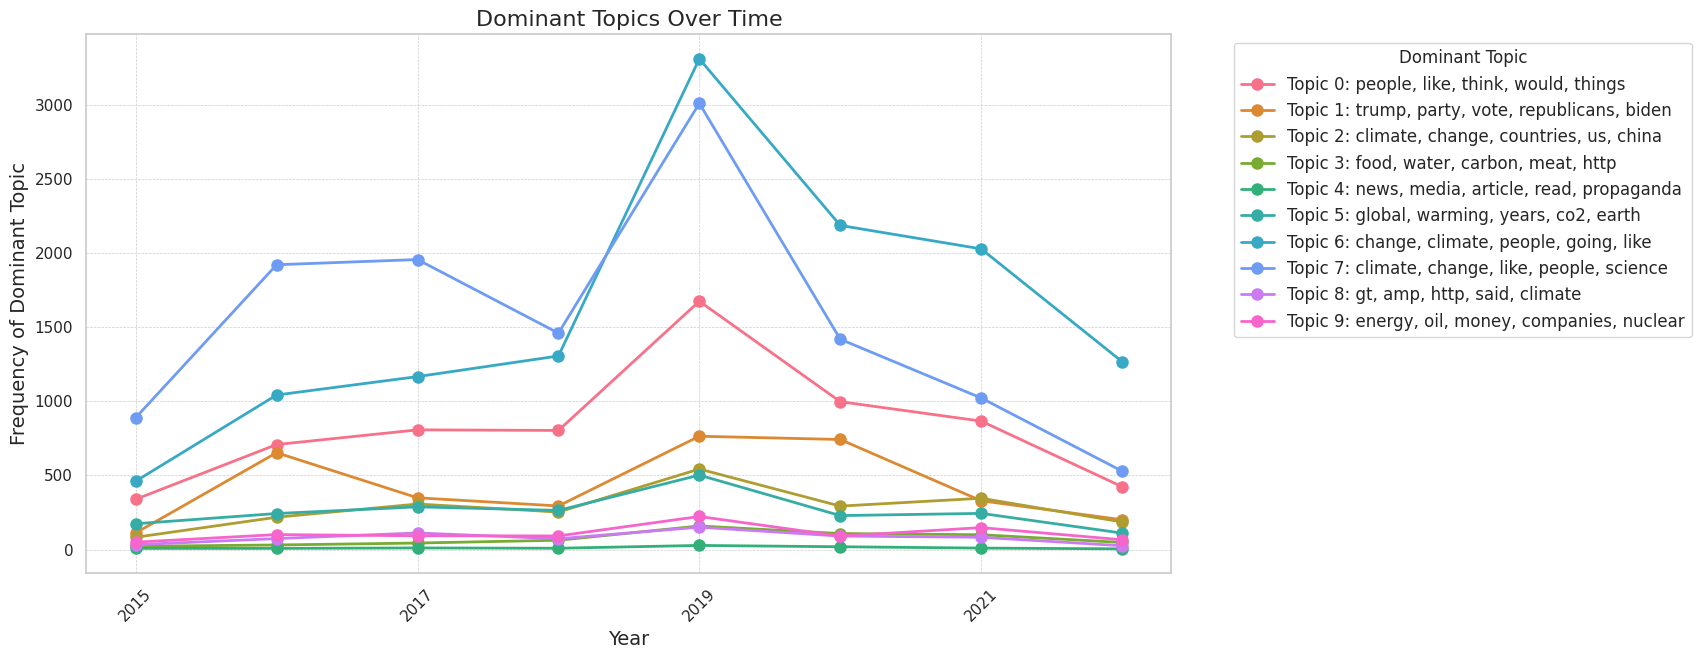

In [ ]:
sns.set_theme(style="whitegrid")
palette = sns.color_palette("husl", len(topic_counts_by_year.columns))

plt.figure(figsize=(14, 7))

for idx, topic in enumerate(topic_counts_by_year.columns):
    plt.plot(topic_counts_by_year.index.year, topic_counts_by_year[topic], marker='o', linewidth=2, markersize=8, label=f'{topic}', color=palette[idx])

plt.title('Dominant Topics Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Frequency of Dominant Topic', fontsize=14)
plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(topic_counts_by_year.index.year[::2], rotation=45)  # Adjust as needed
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

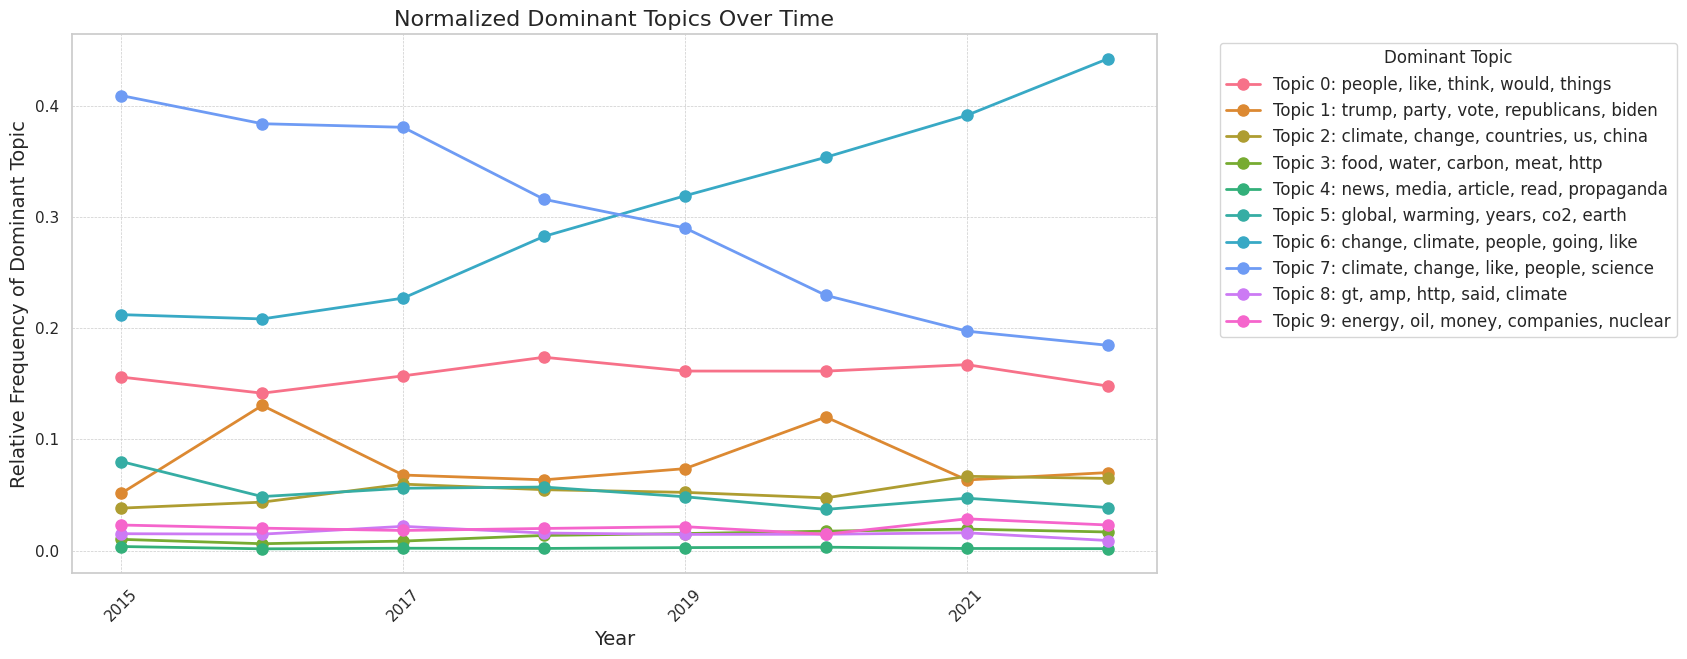

In [24]:
# Normalize frequencies
normalized_topic_counts = topic_counts_by_year.div(topic_counts_by_year.sum(axis=1), axis=0)

# Plot the normalized frequencies
sns.set_theme(style="whitegrid")
palette = sns.color_palette("husl", len(normalized_topic_counts.columns))

plt.figure(figsize=(14, 7))
for idx, topic in enumerate(normalized_topic_counts.columns):
    plt.plot(normalized_topic_counts.index.year, normalized_topic_counts[topic], marker='o', linewidth=2, markersize=8, label=f'{topic}', color=palette[idx])

plt.title('Normalized Dominant Topics Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Relative Frequency of Dominant Topic', fontsize=14)
plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(normalized_topic_counts.index.year[::2], rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

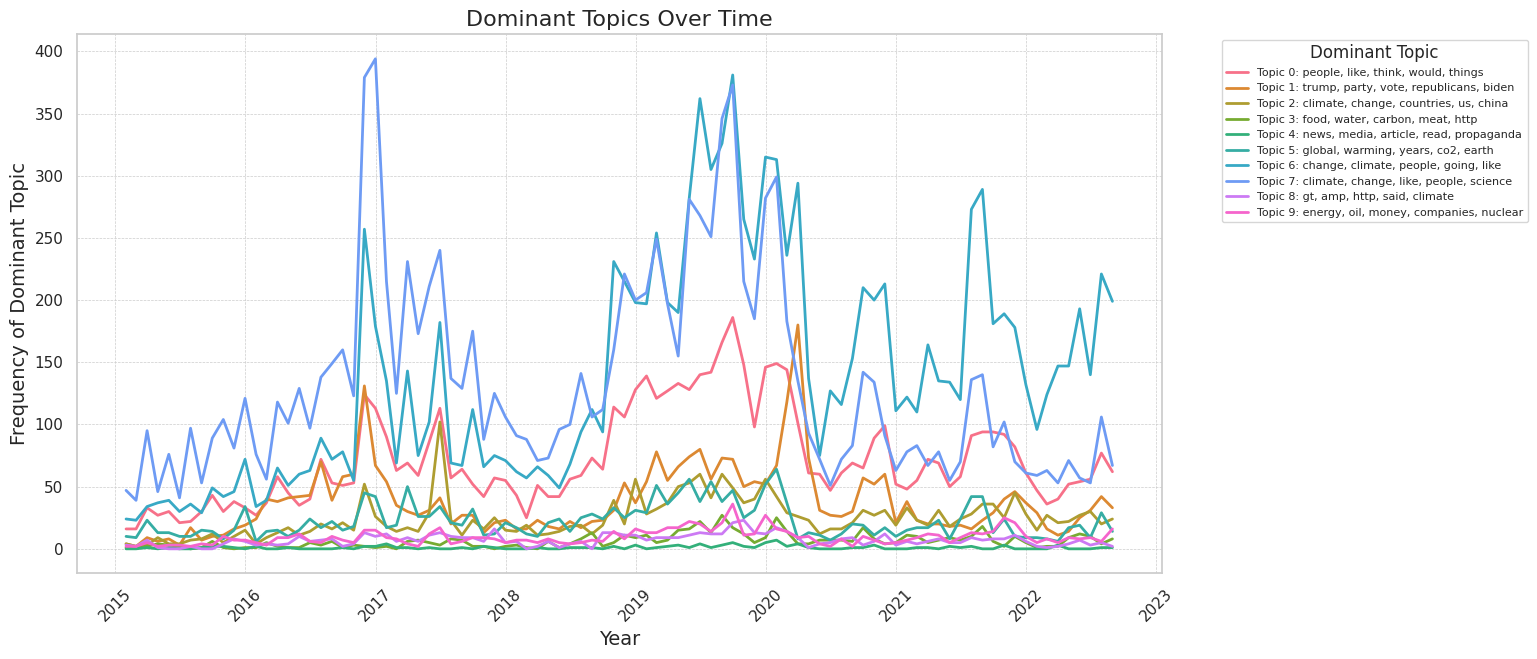

In [ ]:
import matplotlib.dates as mdates
# Set the Seaborn theme and palette
sns.set_theme(style="whitegrid")
palette = sns.color_palette("husl", len(topic_counts_by_month.columns))

plt.figure(figsize=(14, 7))

# Plot each topic with its respective color
for idx, topic in enumerate(topic_counts_by_month.columns):
    plt.plot(topic_counts_by_month.index, topic_counts_by_month[topic], linewidth=2, label=f'{topic}', color=palette[idx])

# Set title and labels with appropriate font sizes
plt.title('Dominant Topics Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)  # Adjusted to 'Year'
plt.ylabel('Frequency of Dominant Topic', fontsize=14)

# Set legend outside the plot
plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Format the x-axis to show only the year and ensure labels don't overlap
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Modified to show only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Changed to YearLocator

# Add grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

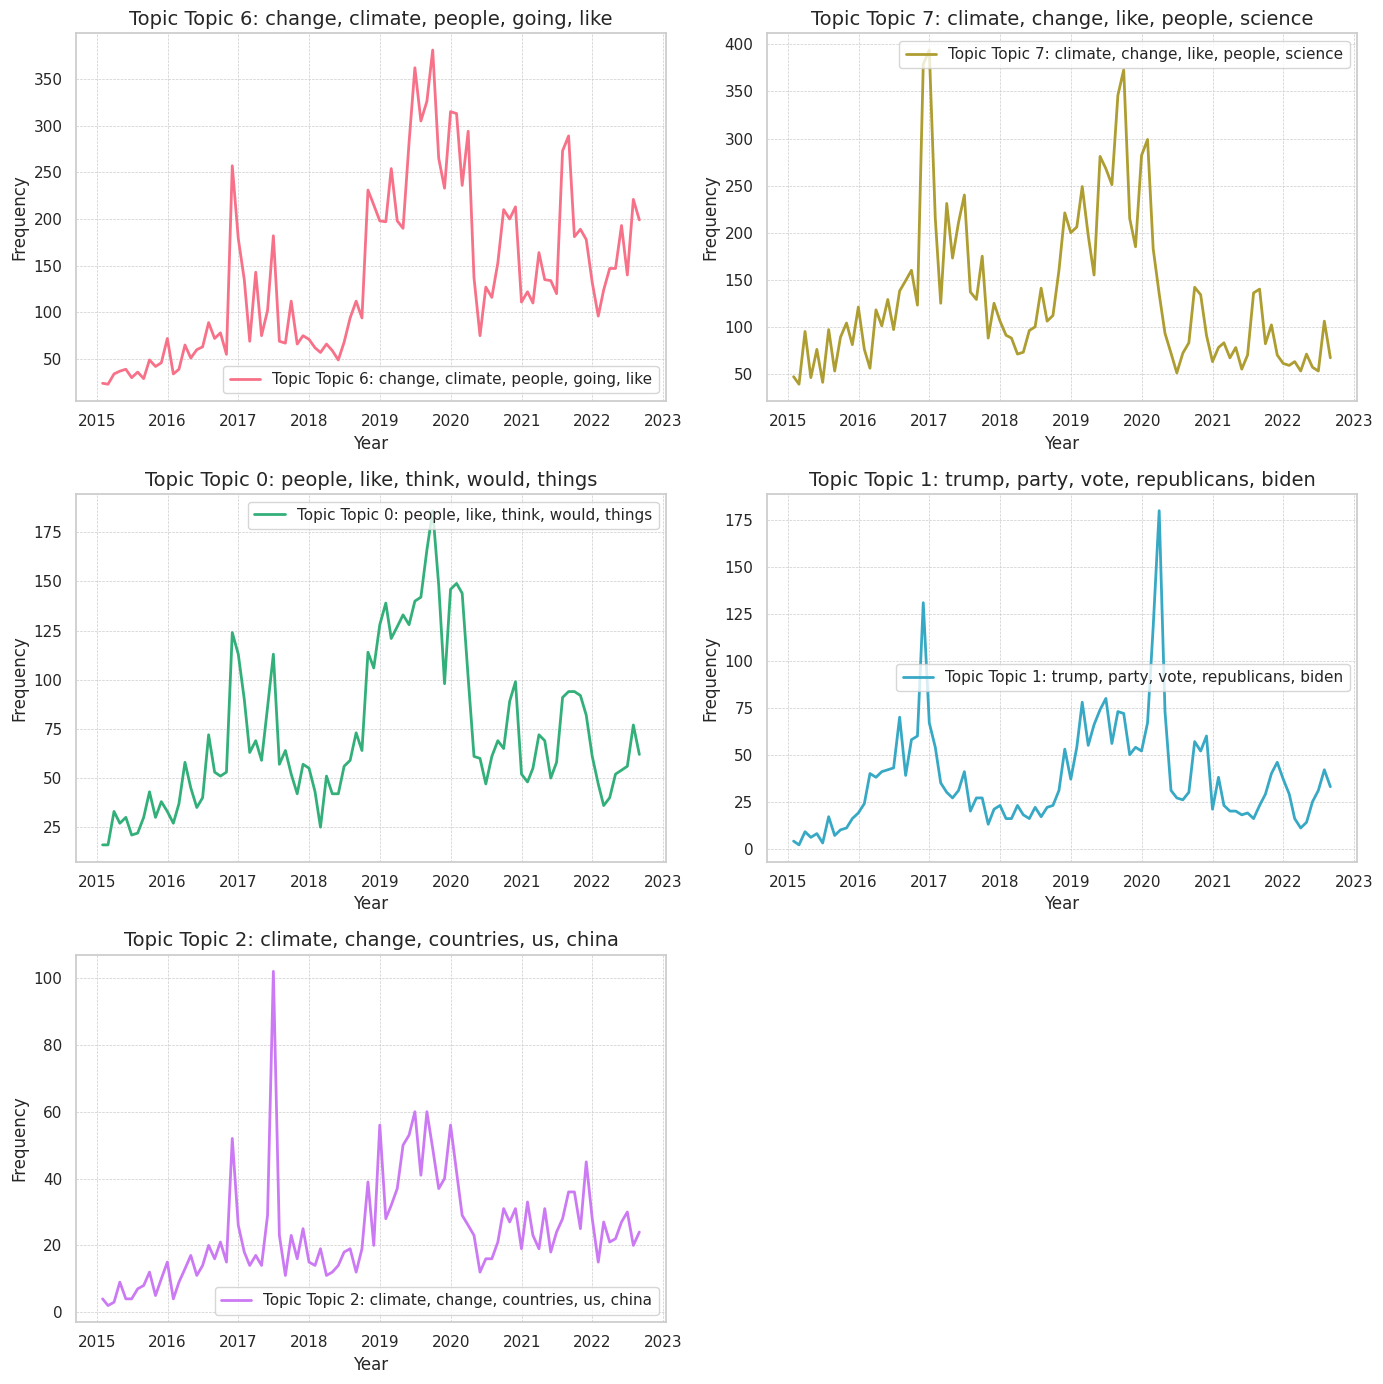

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn theme
sns.set_theme(style="whitegrid")

# Sum up the frequencies for each topic over all months
topic_sums = topic_counts_by_month.sum()

# Select the top 5 topics based on the sum of frequencies
top_topics = topic_sums.nlargest(5).index

# Define the number of rows and columns for the subplot grid
n_rows = 3
n_cols = 2

# Create a figure to hold the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 14), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the top 5 topics and create a subplot for each
for idx, topic in enumerate(top_topics):
    ax = axes[idx]
    ax.plot(topic_counts_by_month.index, topic_counts_by_month[topic], linewidth=2, label=f'Topic {topic}', color=sns.color_palette("husl", len(top_topics))[idx])
    ax.set_title(f'Topic {topic}', fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()

# If there are any empty subplots (due to an odd number of top topics), hide them
for ax in axes[idx + 1:]:
    ax.axis('off')

# Adjust the layout
plt.tight_layout()

plt.show()


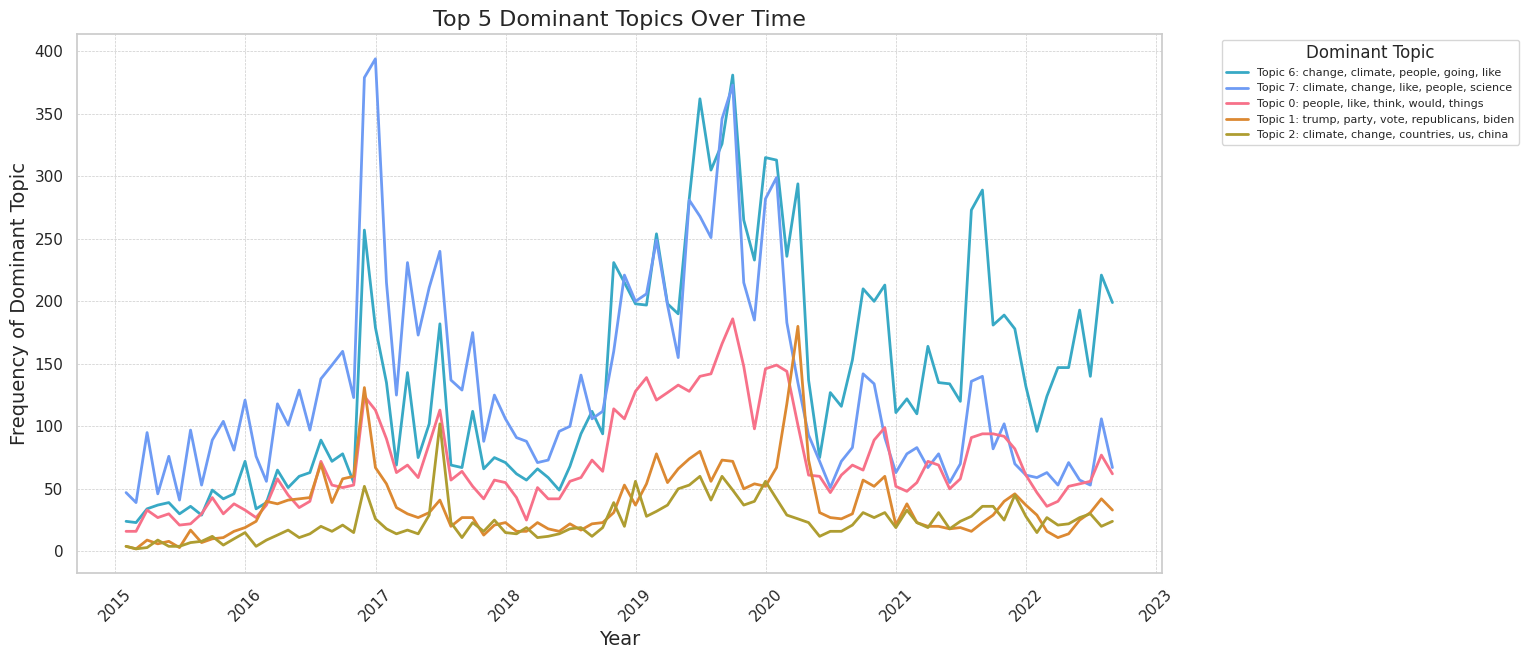

In [ ]:
import matplotlib.dates as mdates
# Set the Seaborn theme and palette
sns.set_theme(style="whitegrid")

# Sum up the frequencies for each topic over all months
topic_sums = topic_counts_by_month.sum()

# Select the top 5 topics based on the sum of frequencies
top_topics = topic_sums.nlargest(5).index

# Filter the palette to include colors only for the top 5 topics
top_palette = [sns.color_palette("husl", len(topic_counts_by_month.columns))[topic_counts_by_month.columns.get_loc(topic)] for topic in top_topics]

plt.figure(figsize=(14, 7))

# Plot each of the top 5 topics with its respective color
for idx, topic in enumerate(top_topics):
    plt.plot(topic_counts_by_month.index, topic_counts_by_month[topic], linewidth=2, label=f'{topic}', color=top_palette[idx])

# Set title and labels with appropriate font sizes
plt.title('Top 5 Dominant Topics Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Frequency of Dominant Topic', fontsize=14)

# Set legend outside the plot
plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Format the x-axis to show only the year and ensure labels don't overlap
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Add grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()


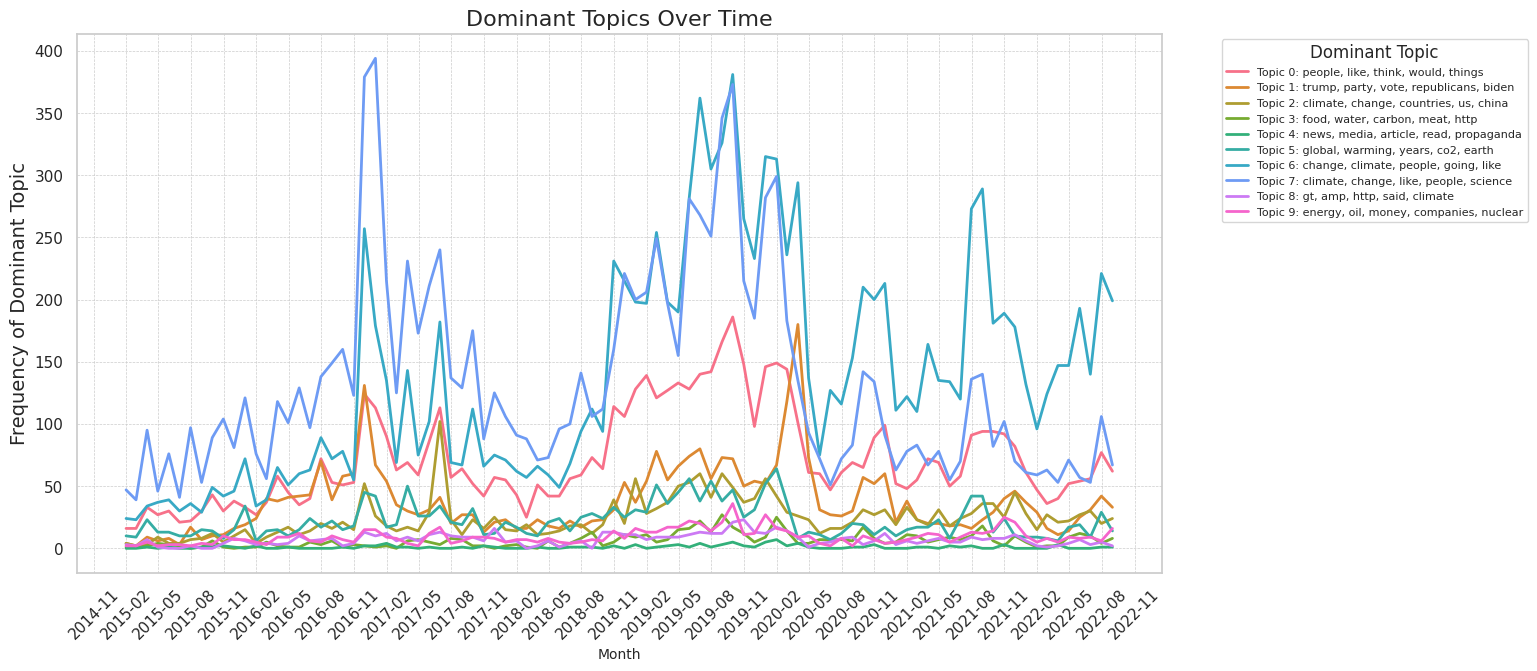

In [ ]:
import matplotlib.dates as mdates
# Set the Seaborn theme and palette
sns.set_theme(style="whitegrid")
palette = sns.color_palette("husl", len(topic_counts_by_month.columns))

plt.figure(figsize=(14, 7))

# Plot each topic with its respective color
for idx, topic in enumerate(topic_counts_by_month.columns):
    plt.plot(topic_counts_by_month.index, topic_counts_by_month[topic],linewidth=2, label=f'{topic}', color=palette[idx])

# Set title and labels with appropriate font sizes
plt.title('Dominant Topics Over Time', fontsize=16)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Frequency of Dominant Topic', fontsize=14)

# Set legend outside the plot
plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Format the x-axis to show both month and year, and ensure labels don't overlap
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

# Add grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

### Features for Topic Prediction Model

In [ ]:
# Load spaCy with the medium English model
nlp = spacy.load("en_core_web_md")

In [ ]:
# Extract LDA topic distributions
# lda_topic_distributions = [lda_model.get_document_topics(doc) for doc in corpus]

# Get word embeddings for each document
document_embeddings = []

for doc in documents:
    tokens = nlp(doc.lower())
    # Average the word vectors for each document
    doc_embedding = np.mean([token.vector for token in tokens if token.is_alpha], axis=0)
    document_embeddings.append(doc_embedding)



In [ ]:
# Map inferred topic labels to desired labels
inferred_labels = {
    0: "General Public Opinion",
    1: "Political Perspectives on Climate Change",
    2: "Global Climate Change",
    3: "Food and Climate",
    4: "Media and Propaganda",
    5: "Global Warming and Environmental Changes",
    6: "Climate Change Impact",
    7: "Climate Change Science and Beliefs",
    8: "General Discussions",
    9: "Energy and Resources",
}

In [ ]:
document_lengths = [len(doc.split()) for doc in documents]

In [ ]:
from textblob import TextBlob

# Example function for sentiment analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to each document in the original dataset
sentiment_values = [get_sentiment(doc) for doc in documents]

In [ ]:
sentiment = sample_comments['sentiment']

In [ ]:
lda_topic_distributions[0]

[(0, 0.22961248),
 (1, 0.22175089),
 (2, 0.019781161),
 (3, 0.04024208),
 (4, 0.051535837),
 (6, 0.34291607),
 (9, 0.09106521)]

In [ ]:
total_topics = 10

# Number of documents
num_documents = len(lda_topic_distributions)

# Initialize an array of zeros with shape (num_documents, total_topics)
topic_distribution_array = np.zeros((num_documents, total_topics))

# Populate the array with the actual topic probabilities
for doc_index, doc_topics in enumerate(lda_topic_distributions):
    for topic_index, probability in doc_topics:
        topic_distribution_array[doc_index, topic_index] = probability

In [ ]:
# Prepare data for classification
X = [np.mean([topic[1] for topic in topic_distribution]) for topic_distribution in lda_topic_distributions]
y_inferred = [max(topic_distribution, key=lambda x: x[1])[0] for topic_distribution in lda_topic_distributions]

# Map inferred labels to desired labels
y_desired = [inferred_labels[label] for label in y_inferred]

# Convert X to a 2D array
X = np.array(X).reshape(-1, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_desired, test_size=0.2, random_state=42)

# Train a classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.3156182212581345


In [ ]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions and evaluate
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.2913955169920463


### Predicting Topic Based on Word Embeddings

In [ ]:
# Prepare data for classification
X = document_embeddings
y_inferred = [max(topic_distribution, key=lambda x: x[1])[0] for topic_distribution in lda_topic_distributions]

# Map inferred labels to desired labels
y_desired = [inferred_labels[label] for label in y_inferred]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_desired, test_size=0.2, random_state=42)

# Train a classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions and evaluate
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7247529525186792
Accuracy: 0.5911062906724512


In [ ]:
# Prepare data for classification
X = np.column_stack((document_embeddings, sentiment, document_lengths))
y_inferred = [max(topic_distribution, key=lambda x: x[1])[0] for topic_distribution in lda_topic_distributions]

# Map inferred labels to desired labels
y_desired = [inferred_labels[label] for label in y_inferred]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_desired, test_size=0.2, random_state=42)

# Train a classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions and evaluate
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.596649795131357
Accuracy: 0.5936370209689081


In [ ]:
# Prepare data for classification
X = np.column_stack((topic_distribution_array, document_embeddings, sentiment, document_lengths))
y_inferred = [max(topic_distribution, key=lambda x: x[1])[0] for topic_distribution in lda_topic_distributions]

# Map inferred labels to desired labels
y_desired = [inferred_labels[label] for label in y_inferred]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_desired, test_size=0.2, random_state=42)

# Train a classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6191853458664739


In [ ]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions and evaluate
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.918173053747891


In [ ]:
# Prepare data for classification
X = np.column_stack((topic_distribution_array, document_embeddings, document_lengths))
y_inferred = [max(topic_distribution, key=lambda x: x[1])[0] for topic_distribution in lda_topic_distributions]

# Map inferred labels to desired labels
y_desired = [inferred_labels[label] for label in y_inferred]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_desired, test_size=0.2, random_state=42)

# Train a classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions and evaluate
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6099060014461316
Accuracy: 0.916003856350928


In [ ]:
# Prepare data for classification
X = topic_distribution_array
y_inferred = [max(topic_distribution, key=lambda x: x[1])[0] for topic_distribution in lda_topic_distributions]

# Map inferred labels to desired labels
y_desired = [inferred_labels[label] for label in y_inferred]
y_desired = np.array(y_desired)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_desired, test_size=0.2, random_state=42)

# Train a classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions and evaluate
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9859002169197397
Accuracy: 0.9887924801156905


In [ ]:
from sklearn.ensemble import VotingClassifier

# Example with Logistic Regression and Random Forest
classifier1 = LogisticRegression()
classifier2 = RandomForestClassifier(n_estimators=100, random_state=42)

ensemble_classifier = VotingClassifier(estimators=[('lr', classifier1), ('rf', classifier2)], voting='soft')

ensemble_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = ensemble_classifier.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, predictions)
print(f"Ensemble Model Accuracy: {accuracy}")

Ensemble Model Accuracy: 0.7158351409978309


In [ ]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions and evaluate
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.589298626174982


In [ ]:
X = np.column_stack((topic_distribution_array, document_embeddings, sentiment_values, document_lengths))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_desired, test_size=0.2, random_state=42)

# Initialize and train your classifier (Random Forest as an example)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9201012292118583


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(classifier, X, y_desired, cv=5)
print(f"Cross-Validation Scores: {cross_val_scores}")

Cross-Validation Scores: [0.92287298 0.91937816 0.91997107 0.92370736 0.92226106]


### Exploring Topic Modeling for Subreddits

In [ ]:
df_category = pd.read_csv(path_gdrive + '/' + 'by_category/comments_filtered.csv')

In [ ]:
df_category.head(5)

,subreddit.name,date,body,sentiment,label
0,futurology,2022-08-31 23:53:39,Blaming environmentalists for the failure of n...,0.3094,1.0
1,canada,2022-08-31 23:27:11,"['Pipelines will be blown up,' says David Suzu...",-0.9719,0.0
2,australia,2022-08-31 23:19:53,\n&gt;You don't want there to be any actual ac...,-0.8434,0.0
3,collapse,2022-08-31 23:17:48,&gt; Sounds like we have 20 years\n\nWhy lie a...,-0.6249,0.0
4,canada,2022-08-31 23:14:46,I'm not running from anything.\n\nI haven't ex...,0.7942,1.0


In [ ]:
df_category.shape

(307041, 5)

### Exploring Topic Modeling for Canada Subreddit

In [ ]:
df_canada = df_category[df_category['subreddit.name'] == 'canada']
df_canada.shape

(59037, 5)

In [ ]:
df_canada_sample = df_canada.sample(frac=0.05, random_state=42)

In [ ]:
documents = df_canada_sample['body'].tolist()

# Tokenize and preprocess the documents
stop_words = set(stopwords.words('english'))
tokenized_documents = [word_tokenize(doc.lower()) for doc in documents]
filtered_documents = [
    [
        word
        for word in doc
        if word.isalnum() and word not in stop_words and not re.match(r'https?://\S+|www\.\S+|http\S+', word)
    ]
    for doc in tokenized_documents
]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(filtered_documents)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in filtered_documents]

random_seed = 42  # You can use any integer value as the seed
gensim_seed = gensim.utils.get_random_state(random_seed)

# Build the LDA model
num_topics = 10
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=gensim_seed)

# Print the topics and associated words
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.041*"minister" + 0.029*"honourable" + 0.007*"affairs" + 0.006*"development" + 0.004*"racial" + 0.004*"cabinet" + 0.003*"prime" + 0.003*"tourism" + 0.003*"health" + 0.003*"moderates"')
(1, '0.007*"gt" + 0.005*"climate" + 0.005*"change" + 0.004*"youth" + 0.004*"nuance" + 0.003*"poll" + 0.003*"students" + 0.003*"today" + 0.003*"school" + 0.003*"saving"')
(2, '0.026*"climate" + 0.025*"change" + 0.013*"like" + 0.009*"people" + 0.006*"get" + 0.006*"would" + 0.005*"canada" + 0.005*"need" + 0.005*"one" + 0.005*"oil"')
(3, '0.045*"climate" + 0.038*"change" + 0.007*"like" + 0.006*"science" + 0.006*"years" + 0.006*"weather" + 0.006*"global" + 0.006*"warming" + 0.005*"people" + 0.005*"gt"')
(4, '0.042*"change" + 0.042*"climate" + 0.038*"party" + 0.022*"vote" + 0.020*"conservative" + 0.015*"conservatives" + 0.013*"cpc" + 0.012*"policy" + 0.011*"liberals" + 0.011*"ndp"')
(5, '0.019*"climate" + 0.018*"change" + 0.012*"people" + 0.008*"gt" + 0.007*"would" + 0.005*"like" + 0.005*"even" + 0.005*"

In [ ]:
dominant_topic_and_words = []

for doc_bow in corpus:
    # Get document topics and their probabilities
    doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)

    # Find the dominant topic (the one with the highest probability)
    dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]

    # Get the top words for the dominant topic
    top_words = [word for word, prob in lda_model.show_topic(dominant_topic, topn=5)]

    # Combine the top words into a single string
    top_words_str = ", ".join(top_words)

    # Combine the dominant topic index and top words into a single string
    topic_and_words = f"Topic {dominant_topic}: {top_words_str}"

    dominant_topic_and_words.append(topic_and_words)


In [ ]:
df_canada_sample['dominant_topic'] = dominant_topic_and_words

In [ ]:
df_canada_sample.head()

,subreddit.name,date,body,sentiment,label,top_5_topics,dominant_topic
107455,canada,2020-07-15 01:13:28,"Again, a passing reference made in their elect...",-0.7306,0.0,"[3, 2, 4, 5, 7]","Topic 3: climate, change, like, science, years"
83743,canada,2021-03-20 00:01:07,"Get rid of the climate-change deniers, the ant...",-0.2732,0.0,"[5, 0, 4, 8, 3]","Topic 5: climate, change, people, gt, would"
236900,canada,2018-03-28 20:09:54,For every nation ruined by climate change two ...,-0.1531,0.0,"[2, 3, 8, 7, 5]","Topic 2: climate, change, like, people, get"
287914,canada,2016-07-26 19:04:28,&gt; Does anyone really think a carbon tax wil...,0.6597,1.0,"[8, 7, 3, 2, 5]","Topic 8: change, climate, carbon, tax, people"
68516,canada,2021-07-14 17:24:50,Good. Our Navy is pathetic and id expect a lot...,0.6590,1.0,"[2, 3, 7, 8, 5]","Topic 2: climate, change, like, people, get"


In [ ]:
# Convert the 'date' column to datetime format if it's not already
df_canada_sample['date'] = pd.to_datetime(df_canada_sample['date'])

# Set the 'date' column as the DataFrame's index
df_canada_sample.set_index('date', inplace=True)

# Resample the data by a time period (e.g., 'M' for monthly) and get the most frequent dominant topic for each period
dominant_topic_over_time = df_canada_sample['dominant_topic'].resample('M').agg(lambda x:x.value_counts().index[0])


<Figure size 1200x600 with 0 Axes>

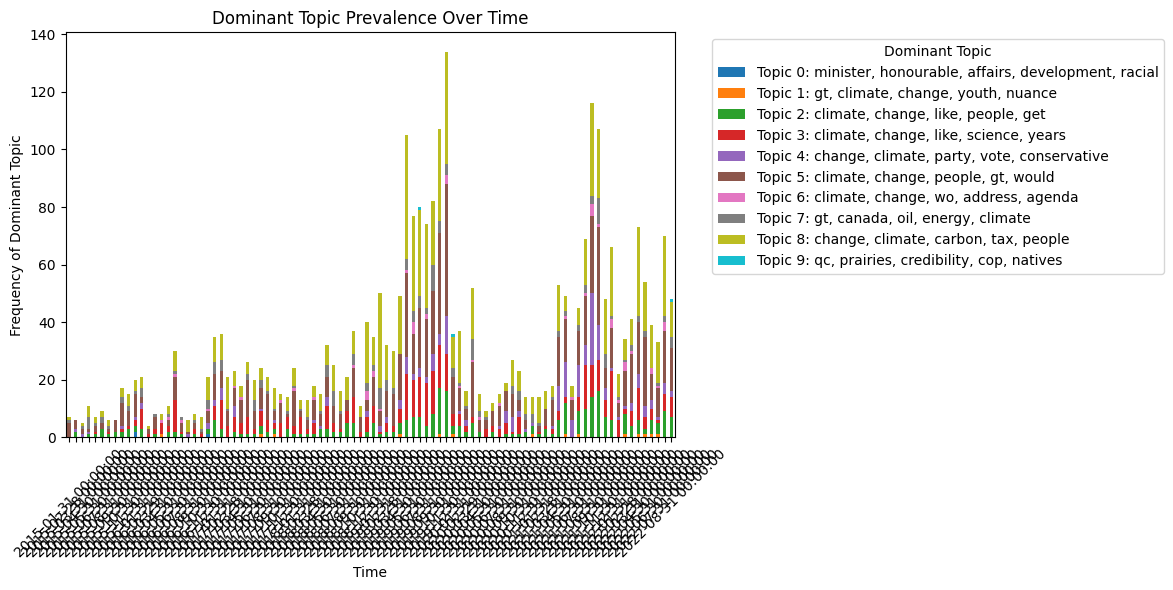

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Resample and count occurrences of each dominant topic per time period
topic_counts = df_canada_sample.resample('M')['dominant_topic'].apply(lambda x: x.value_counts()).unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Dominant Topic Prevalence Over Time')
plt.xlabel('Time')
plt.ylabel('Frequency of Dominant Topic')
plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

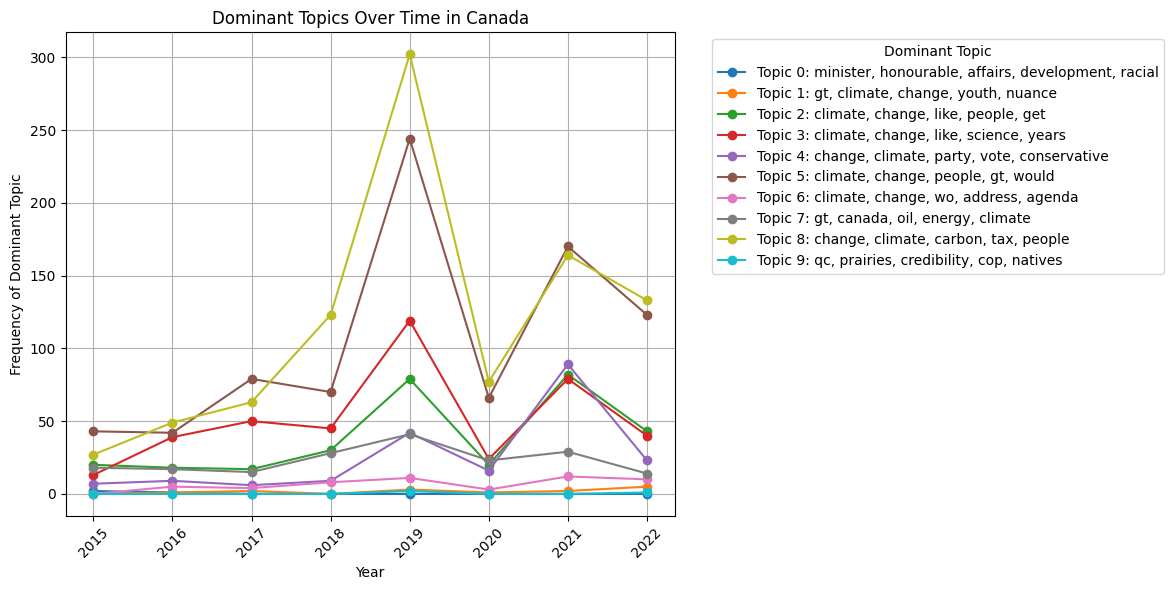

In [ ]:
topic_counts_by_year = df_canada_sample.resample('Y')['dominant_topic'].apply(lambda x: x.value_counts()).unstack(fill_value=0)
plt.figure(figsize=(12, 6))

# Plot each topic as a separate line
for topic in topic_counts_by_year.columns:
    plt.plot(topic_counts_by_year.index.year, topic_counts_by_year[topic], marker='o', label=f'{topic}')

plt.title('Dominant Topics Over Time in Canada')
plt.xlabel('Year')
plt.ylabel('Frequency of Dominant Topic')
plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(topic_counts_by_year.index.year, rotation=45)  # Ensure x-ticks are the years
plt.tight_layout()
plt.show()

### Word Cloud Analysis

---



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

In [ ]:
wordclouds = []

for topic_id in range(num_topics):
    words = [word for word, _ in lda_model.show_topic(topic_id)]
    wordcloud = WordCloud(width=800, height=400).generate(" ".join(words))
    wordclouds.append(wordcloud)

# Step 2: Extract Features from Word Clouds
def extract_word_cloud_features(document):
    features = []
    for wordcloud in wordclouds:
        presence = any(word in document for word in wordcloud.words_)
        features.append(int(presence))
    return features

### Exploring Named Entity Recognition

In [ ]:
!pip install spacy

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
